In [1]:
from packages import kuramoto as kr
from packages import kuramoto_nex as nkr

from packages import plotting

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

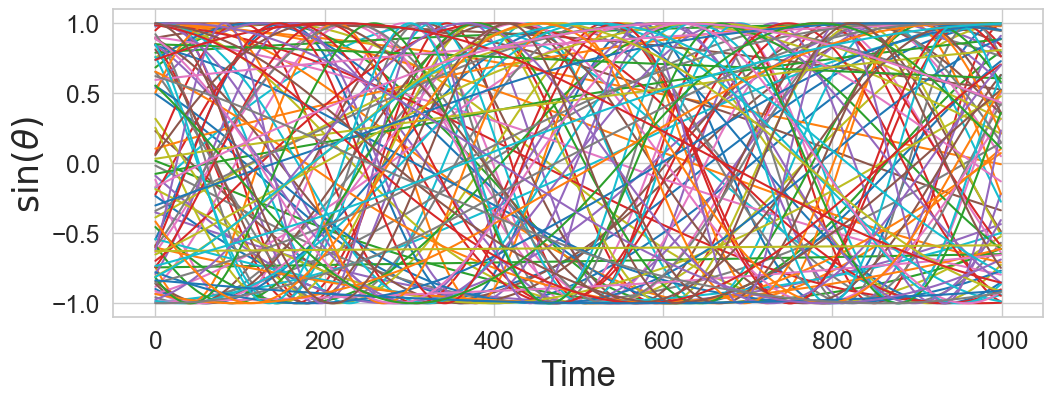

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from tqdm import tqdm, trange

np.random.seed(42)

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.6)

NODE = 100

# Interactions are represented as an adjacency matrix _A_, a 2D numpy ndarray.
# Instantiate a random graph and transform into an adjacency matrix
graph_nx = nx.erdos_renyi_graph(n=NODE, p=1, seed=42) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)

# Instantiate model with parameters
model = kr.Kuramoto(coupling=1.1, dt=0.01, T=10, n_nodes=len(graph))

# Run simulation - output is time series for all nodes (node vs time)
act_mat = model.run(adj_mat=graph)

# Plot all the time series
plotting.plot_activity(act_mat)

In [3]:
t = np.linspace(0, 4, 51)
order_ex = []
variance_ex = []

order_nex = []
variance_nex = []

np.random.seed(42)
init_phase = 2 * np.pi * np.random.random(size=NODE)
natfreqs = np.random.normal(loc = 0, scale = 1, size = NODE)

for k in tqdm(t):
    model_ex = kr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    model_nex = nkr.Kuramoto(coupling=k, dt=0.01, T=10, n_nodes=len(graph), natfreqs=natfreqs)
    # Run simulation - output is time series for all nodes (node vs time)
    act_mat_ex = model_ex.run(adj_mat=graph, angles_vec = init_phase)
    act_mat_nex = model_nex.run(adj_mat=graph, angles_vec = init_phase)

    order_ex.append(model_ex.phase_coherence(act_mat_ex[:,-1]))
    variance_ex.append(model_ex.mean_frequency(act_mat_ex, graph))

    order_nex.append(model_nex.phase_coherence(act_mat_nex[:,-1]))
    variance_nex.append(model_nex.mean_frequency(act_mat_nex, graph))


100%|██████████| 51/51 [00:17<00:00,  2.92it/s]


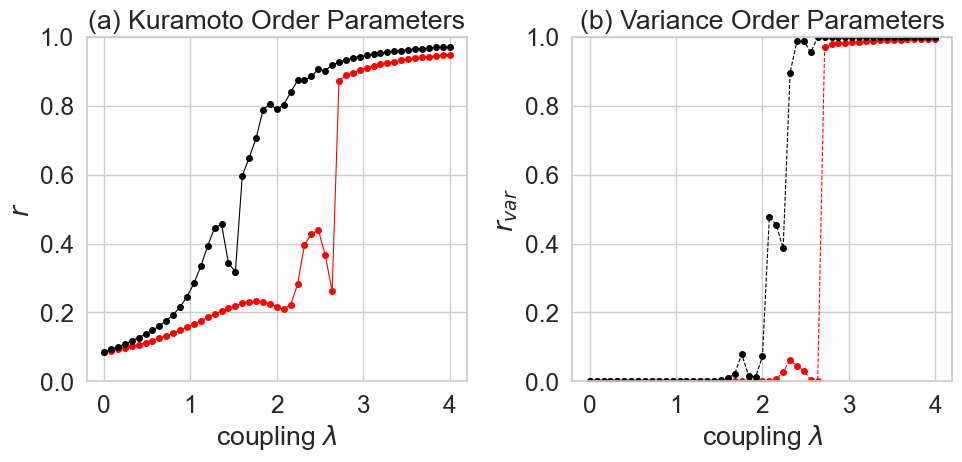

In [4]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
axes[0].plot(t, order_ex, '-o', color='r', linewidth=0.8, markersize=4)
axes[0].plot(t, order_nex, '-o', color='k', linewidth=0.8, markersize=4)

axes[0].set_title('(a) Kuramoto Order Parameters')
axes[0].set_xlabel('coupling $\lambda$')
axes[0].set_ylabel('$r$')
axes[0].set_ylim([0,1])
axes[0].grid(True)

axes[1].plot(t, variance_ex, '--o', color='r', linewidth=0.8, markersize=4)
axes[1].plot(t, variance_nex, '--o', color='k', linewidth=0.8, markersize=4)

axes[1].set_title('(b) Variance Order Parameters')
axes[1].set_xlabel('coupling $\lambda$')
axes[1].set_ylabel('$r_{var}$')
axes[1].set_ylim([0,1])
axes[1].grid(True)

plt.tight_layout()


In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot figure with shared axes
fig = make_subplots(rows=1, cols=2, subplot_titles=["(a) Kuramoto Order Parameters", "(b) Variance Order Parameters"], horizontal_spacing=0.1, shared_xaxes=True)

# Add traces to subplot 1
fig.add_trace(
    go.Scatter(x=t, y=order_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Order Ex'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=t, y=order_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Order Nex'),
    row=1, col=1
)
fig.update_yaxes(title_text='$r$', range=[0,1], row=1, col=1)

# Add traces to subplot 2
fig.add_trace(
    go.Scatter(x=t, y=variance_ex, mode='markers+lines', marker=dict(color='red', size=4), line=dict(width=0.8), name='Variance Ex'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=t, y=variance_nex, mode='markers+lines', marker=dict(color='black', size=4), line=dict(width=0.8), name='Variance Nex'),
    row=1, col=2
)
fig.update_yaxes(title_text=r'$r_{var}$', range=[0,1], row=1, col=2)

# Update layout with synchronized hovermode
fig.update_layout(height=500, width=900, showlegend=False, title_text=f"Kuramoto and Variance Order Parameters (N={NODE})", title_x=0.5, hovermode='x unified')

fig.show()


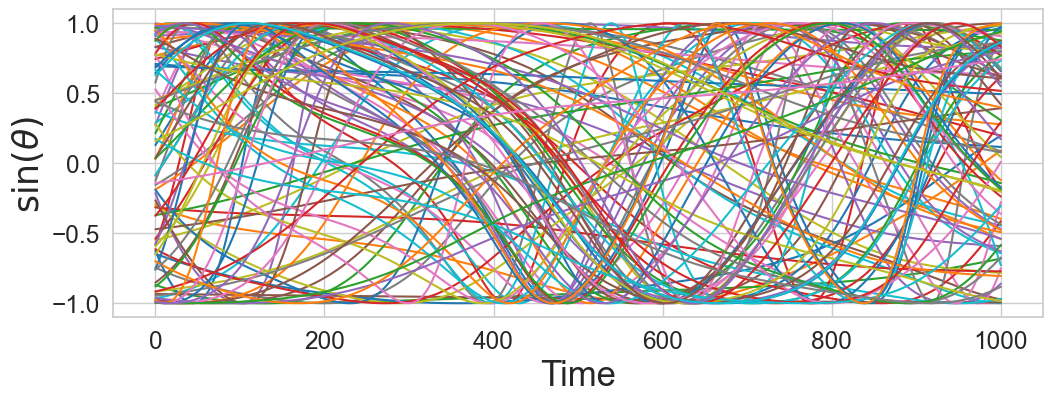

In [6]:
critical_coupling = 2.6
hist = []

critical_model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=10.01, n_nodes=len(graph), natfreqs=natfreqs)
act_mat = critical_model.run(adj_mat=graph, angles_vec = init_phase)
plotting.plot_activity(act_mat)
hist.append(act_mat)

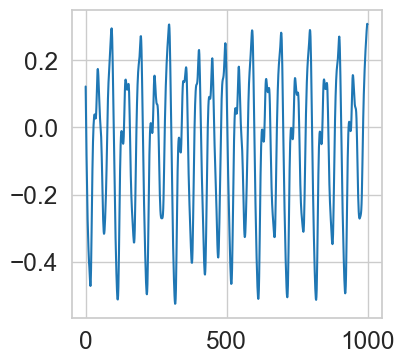

In [7]:
data = np.loadtxt('MackeyGlass.txt')
plt.figure(figsize=(4,4))
plt.plot(data[:1000])

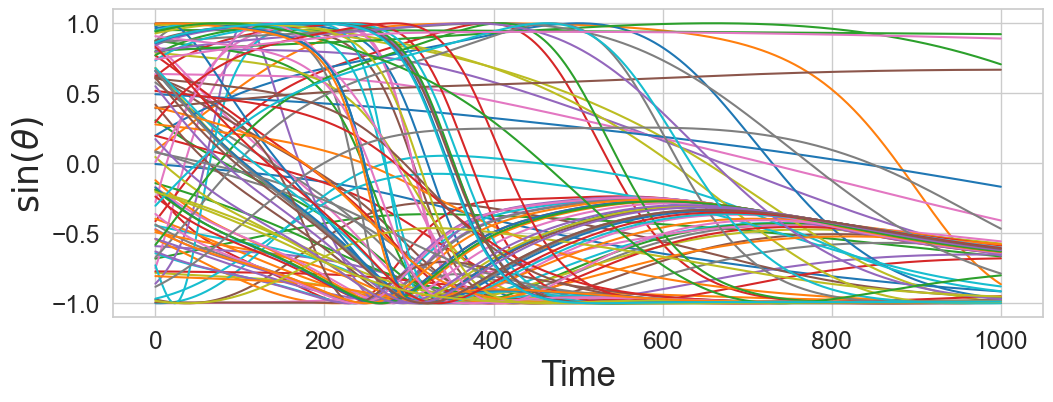

In [8]:
state = act_mat[:,-1]
state[0] += data[0]

act_mat = critical_model.run(adj_mat=graph, angles_vec = state)
plotting.plot_activity(act_mat)
hist.append(act_mat)


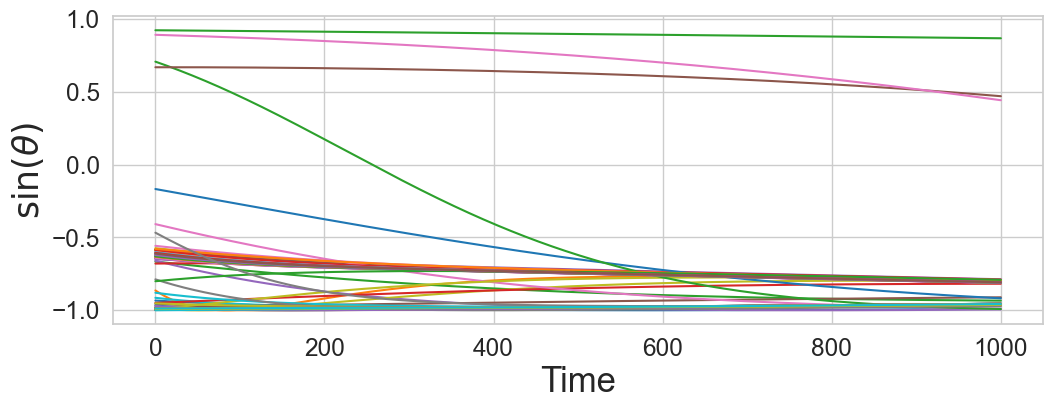

In [9]:
state = act_mat[:,-1]
state[0] += data[1]

act_mat = critical_model.run(adj_mat=graph, angles_vec = state)
plotting.plot_activity(act_mat)
hist.append(act_mat)


In [10]:
hist_stack = np.hstack(hist)
hist_stack.shape

(100, 3003)

<Axes: xlabel='Time', ylabel='$\\sin(\\theta)$'>

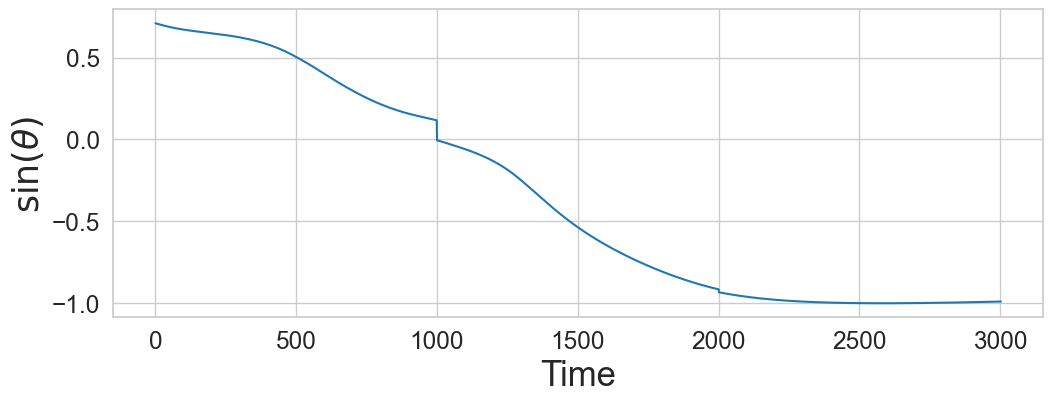

In [11]:
plotting.plot_activity(hist_stack[0])

In [12]:
def getReservoir(matrix, time_interval=10):
    sampled_matrix = matrix[:, ::time_interval]
    diff_matrix = np.diff(sampled_matrix, n=1, axis=1)
    reservoir_t = diff_matrix.flatten(order='K')
    #print(sampled_matrix.shape)
    #print(diff_matrix.shape)
    #print(reservoir_t.shape)

    return reservoir_t

In [13]:
def getLastPhase(matrix):
    return matrix[:,-1]

In [14]:
getReservoir(act_mat, 100).shape

(1000,)

In [15]:
def getPerturbedPhase(input_data, index, phase):
    for (i,j) in enumerate(index):
        phase[j] += input_data[t, i]
    
    return phase

In [16]:
def getNextPhase(matrix, model):
    act_mat = model.run(adj_mat=graph, angles_vec=matrix)
    phase = getLastPhase(matrix=act_mat)
    
    return phase

In [17]:
def ridge_regression(trainRes, trainData, reg):
    ResSize = trainRes.shape[1]
    Wout = np.linalg.solve(np.dot(trainRes.T, trainRes) + reg*np.eye(ResSize), np.dot(trainRes.T, trainData))
    return Wout

In [18]:
ResSize = 1500
push = 500
trainLen = ResSize-push
input_data = data.reshape(-1,1)
trainData = input_data[push+1:push+trainLen+1,:]

sample_interval=10

In [38]:
# Now we are ready to perturb data
input_interval = 1
reservoir = []

act_mat_hist = []

synced_phases = act_mat[:,-1]

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=0.01, n_nodes=NODE, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=input_interval+0.01, n_nodes=NODE, natfreqs=natfreqs)

for t in trange(0, ResSize):
    perturbed_phases = getPerturbedPhase(input_data=input_data, index=[0], phase=synced_phases)
    act_mat = model.run(adj_mat=graph, angles_vec=perturbed_phases)
    
    reservoir.append(getReservoir(matrix=act_mat, time_interval=sample_interval))
    synced_phases = getLastPhase(matrix=act_mat)

    act_mat_hist.append(act_mat)

100%|██████████| 1500/1500 [00:05<00:00, 274.57it/s]


In [39]:
reservoir_T = np.vstack(reservoir)
reservoir_T.shape

(1500, 1000)

In [40]:
trainRes = reservoir_T[push:push+trainLen,:]
print(trainRes.shape, trainData.shape)

(1000, 1000) (1000, 1)


In [41]:
#Wout = np.matmul(np.linalg.pinv(trainRes), trainData)

reg = 1e-8  # regularization coefficient
Wout = ridge_regression(trainRes, trainData, reg)

In [42]:
testLen = 2000
testData = input_data[push+trainLen+1:push+trainLen+1+testLen,:]

target = trainData[-1,:].reshape(-1,1)
target

array([[0.13520412]])

In [43]:
pred = []

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=0.01, n_nodes=NODE, natfreqs=natfreqs)
synced_phases = getNextPhase(matrix=synced_phases, model=model)

model = kr.Kuramoto(coupling=critical_coupling, dt=0.01, T=input_interval+0.01, n_nodes=NODE, natfreqs=natfreqs)

for t in trange(0, testLen):
    for (i,j) in enumerate([0]):
        synced_phases[j] += target[i]
        
    act_mat = model.run(adj_mat=graph, angles_vec = synced_phases)
    act_mat_sampled = act_mat[:, ::sample_interval]
    act_mat_diff = np.diff(act_mat_sampled, n=1, axis=1)
    reservoir_t = act_mat_diff.flatten(order='K')
    pred.append(np.matmul(reservoir_t, Wout))

    synced_phases = getLastPhase(matrix=act_mat)
    target = pred[-1]

100%|██████████| 2000/2000 [00:06<00:00, 289.13it/s]


In [44]:
pred = np.vstack(pred)
pred.shape

(2000, 1)

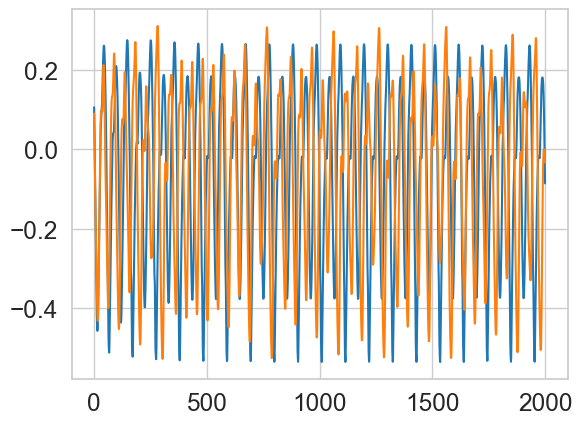

In [46]:
plt.plot(pred)
plt.plot(testData)

In [27]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(testData, pred)**0.5
print(RMSE)

0.3186001537620396


In [28]:
inputIndex = 0
reservoir = np.zeros((1000,1000))
act_mat = critical_model.run(adj_mat=graph, angles_vec = init_phase)
state = act_mat[:,-1]
for t in trange(1000):
    
    state[inputIndex] += data[t]

    act_mat = critical_model.run(adj_mat=graph, angles_vec = state)
    state = act_mat[:,-1]
    reservoir[t] = getReservoir(act_mat, 100)
    

100%|██████████| 1000/1000 [00:14<00:00, 68.24it/s]


In [29]:
np.linalg.pinv(reservoir[10:]).shape

(1000, 990)

In [30]:
data[11:101].reshape(-1, 1).shape

(90, 1)

In [31]:
Wout = np.matmul(np.linalg.pinv(reservoir[10:]), data[11:1001].reshape(-1, 1))

In [32]:
Wout.shape

(1000, 1)

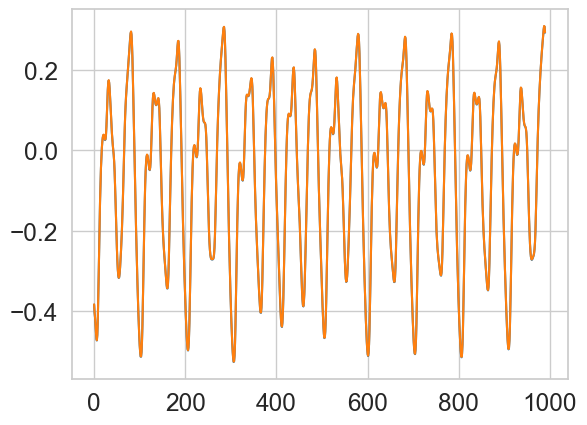

In [33]:
train = np.matmul(reservoir[10:], Wout)

plt.plot(train)
plt.plot(data[11:1001])

In [34]:
inputIndex = 0
pred = np.zeros((200,1))
target = data[1000]
for t in trange(200):
    
    state[inputIndex] += target

    act_mat = critical_model.run(adj_mat=graph, angles_vec = state)
    state = act_mat[:,-1]
    reservoir = getReservoir(act_mat, 100)
    pred[t] = np.matmul(reservoir, Wout)
    target = pred[t]
    

100%|██████████| 200/200 [00:03<00:00, 60.48it/s]


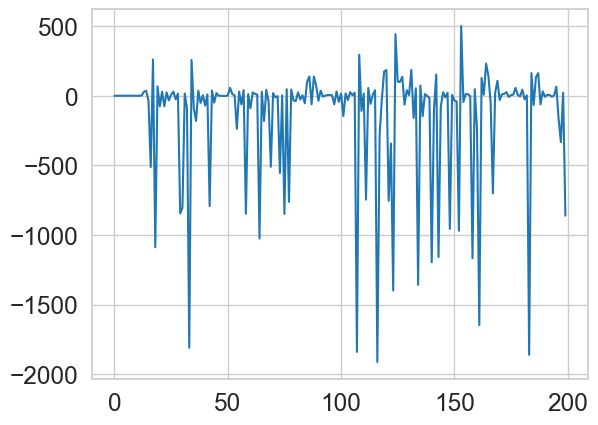

In [35]:
plt.plot(pred)